# PCA for visualization of handwritten digits data

PCA is often used as a technique to aid visualization of high-dimensional data. In this notebook, we'll see how this can be applied to the familiar handwritten digits dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D 
from ipywidgets import interact, fixed
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

First, let's load the data and visualize a few random samples of each type of digit. 

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
X = X/255.0
X.shape

In [ ]:
classes = ['0', '1', '2','3', '4','5', '6', '7', '8', '9']
nclasses = len(classes)

In [ ]:
samples_per_class = 5

figure = plt.figure(figsize=(nclasses*2,(1+samples_per_class*2)));

for idx_cls, cls in enumerate(classes):
  idxs = np.flatnonzero(y == cls)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * nclasses + idx_cls + 1
    p = plt.subplot(samples_per_class, nclasses, plt_idx);
    p = sns.heatmap(np.reshape(X[idx], (28,28)), cmap=plt.cm.gray, 
             xticklabels=False, yticklabels=False, cbar=False);
    p = plt.axis('off');

Each sample is represented by an array of 784 (28x28) pixels.

Let us try to use PCA to project this data onto a smaller number of dimensions.

In [ ]:
pca = PCA(40)  
X_pca = pca.fit_transform(X)

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio by principal component')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Cummulative explained variance ratio')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
X_pca.shape

Next, let's explore how each digit is built up from its principal components. 

In the interactive plot below,

* The original image (sample number `index`) is shown on the top left.
* The reconstructed image using `n_components` principal components is on the top right.
* The bar plot on the bottom left shows the magnitude of each principal component in the selected image (sample number `index`).
* The image on the bottom right shows the `n_component`*th* principal component vector.

Use the interactive plot to explore the data. Make sure to look at a few examples for each digit class (by moving the `index` slider), and build it up one principal component at a time (by moving the `n_components` slider).

In [ ]:
from ipywidgets import interactive
from ipywidgets import Layout
import ipywidgets as widgets

def progressive_plot(index, n_components):
    i = n_components - 1
    img = X[index]
    img_pc = X_pca[index]
    plt.figure(figsize=(12, 8))
    # Plot the original image
    plt.subplot(2, 2, 1)
    plt.imshow(img.reshape((28, 28)), cmap='gray')
    plt.title('Original image')
    plt.xticks([])
    plt.yticks([])
    # Plot the reconstructed image
    plt.subplot(2, 2, 2)
    if i == -1:
        plt.imshow(pca.mean_.reshape((28, 28)), cmap='gray')
        plt.title('Mean')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow((np.dot(img_pc[:i+1], pca.components_[:i+1])
                    + pca.mean_).reshape((28, 28)), cmap='gray')
        plt.title('Principal components 0 to {} + mean'.format(i))
        plt.xticks([])
        plt.yticks([])
    # Plot the bargraph
    plt.subplot(2, 2, 3)
    bars = plt.bar(range(pca.n_components_), img_pc, color='lightgray')
    if i >= 0:
        for j in range(n_components):
            bars[j].set_color('#6495ED')
        bars[i].set_color('r')
    plt.title('Image principal components magnitude')
    plt.xlabel('Principal component')
    plt.ylabel('Magnitude')
    # Plot the scaled principal component vector being added
    plt.subplot(2, 2, 4)
    if i == -1:
        plt.imshow(pca.mean_.reshape((28, 28)), cmap='gray')
        plt.title('Mean')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow((img_pc[i] * pca.components_[i]) .reshape((28, 28)), cmap='gray')
        plt.title('Principal component vector {} * {:.3g}'.format(i, img_pc[i]))
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

style = {'description_width': 'initial'}
layout = Layout(width="800px")
index = widgets.IntSlider(min=0, max=len(X) - 1, value=19325, style=style, layout=layout)
n_components = widgets.IntSlider(min=0, max=len(pca.components_), value=0, style=style, layout=layout)
interactive(progressive_plot, index=index, n_components=n_components)


Based on this interactive, can you say which samples (which class of digits) are likely to have a very large positive magnitude for the first principal component (PC 0)? Can you say which samples (which class of digits) are likely to have a very large negative magnitude for the first principal component (PC 0)? 

To test your understanding, we will visualize this data. Since we have the labels, we'll color each point according to its label.

We will select some random samples to visualize:

In [ ]:
random_samples = np.random.choice(np.arange(0, X_pca.shape[0]), 5000)

Then we can see them in 2D:

In [ ]:
plt.scatter(X_pca[random_samples, 0], X_pca[random_samples, 1],
            c=y[random_samples].astype(int), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.colorbar();

And in 3D (you can move the sliders to change your point of view):

In [ ]:
def plot_3D(elev=30, azim=30, X=X_pca, y=y):

  fig = plt.figure(figsize=(15,15));
  ax = fig.add_subplot(111, projection='3d');
  ax.view_init(elev=elev, azim=azim)

  p = ax.scatter3D(X[:,0], X[:,1], X[:,2], c=y, s=20,
                   alpha=0.5, cmap=plt.cm.get_cmap('tab10', 10));
  ax.set_xlabel('PC 0');
  ax.set_ylabel('PC 1');
  ax.set_zlabel('PC 2');

  axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='center left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

  fig.colorbar(p, cax=axins);

interact(plot_3D, elev=90, azim=90,
         X=fixed(X_pca[random_samples]), y=fixed(y[random_samples].astype(int)));

## Questions

Answer the following questions. Don't submit this notebook - just submit your answers, including the images.

1. Which class of digits will have a very large *positive* weight for the first principal component, and why? 
 * Show a screenshot of the interactive with a sample from this class, with `n_components` = 1 (i.e. the  reconstructed image includes the mean and the first principal component, and the first bar in the plot on the bottom left is shaded in red). Explain how this visualization supports your answer.
 * Show a screenshot of the 2D or 3D visualization of samples from the data. Annotate it to show where the class you mentioned is represented (for example, draw a circle around the samples from that class, or an arrow pointing to those samples.) Explain how this visualization supports your answer.

2. Which class of digits will have a very large *negative* weight for the first principal component, and why? 
 * Show a screenshot of the interactive with a sample from this class, with `n_components` = 1 (i.e. the  reconstructed image includes the mean and the first principal component, and the first bar in the plot on the bottom left is shaded in red). Explain how this visualization supports your answer.
 * Show a screenshot of the 2D or 3D visualization of samples from the data. Annotate it to show where the class you mentioned is represented (for example, draw a circle around the samples from that class, or an arrow pointing to those samples.) Explain how this visualization supports your answer.

### Solutions

The first principal component includes positive values (white pixels) for pixels in an oval shape near the center of the image, and negative values (black pixels) for pixels in the center of the oval.

It is clear that the 0 digits will mostly have a large positive weight for this component, since the zero digit is expected to include the oval shape where the first PC has positive values. The 1 digits will mostly have a large negative weight for this component, since they tend to have pixels marked in a vertical line down the center of the image, where the first PC has negative values, and not in the area around it, where the first PC has positive values.

We can see this in the interactive visualization - here's an example of a 0 digit (left) and a 1 digit (right). In the 0 digit visualization, the first PC has a large positive weight (red bar) and the white pixels on the bottom right panel show that the contribution of the first PC to the reconstructed image is an oval shape. In the 1 digit visualization, the first PC has a large negative weight (red bar), and the white pixels on the bottom right panel show that the contribution of the first PC to the reconstructed image is a vertical line in the center of the image

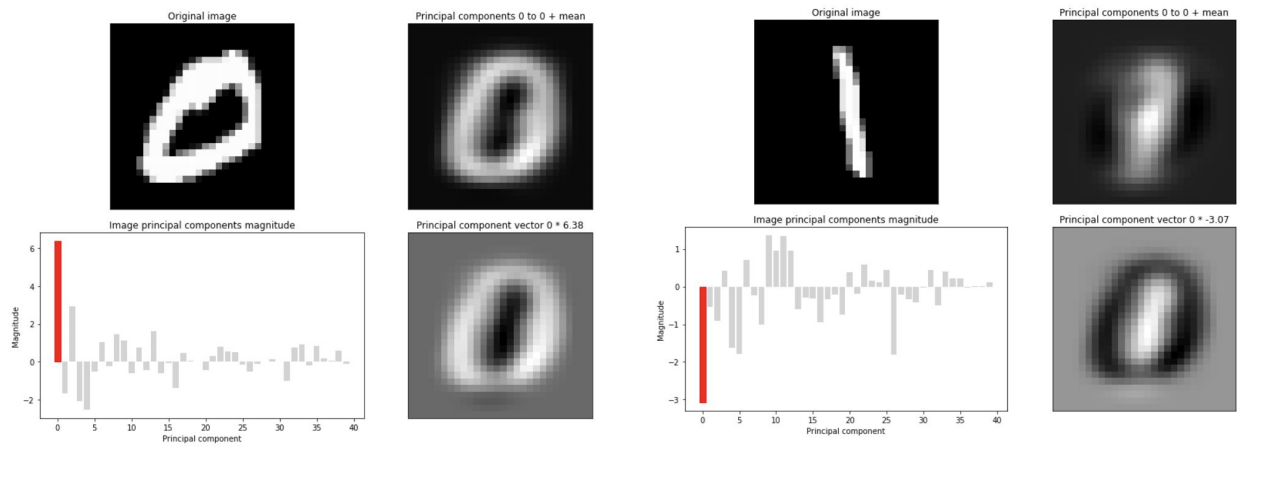

We can also see this in the visualization of the samples - here, the orange samples circled on the left are 1 digits, and they have a negative value on the PC0 axis. The blue samples circled on the right are 0 digits, and they have a
positive value on the PC0 axis.

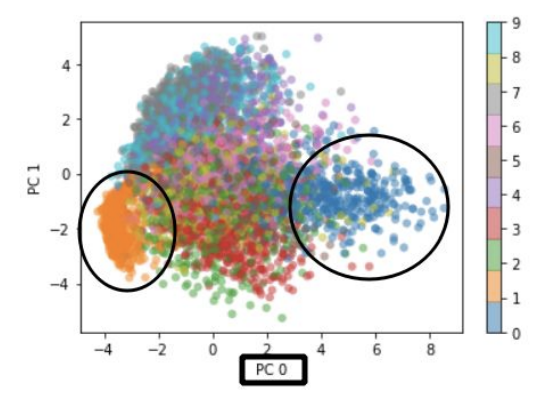